In [32]:
import io
import os
import platform
import pdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.pyplot import cm

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing

In [33]:
def load_model(city, model, path='./'):
    
    # file name and path 
    filename = path + '{}.pt'.format(city)
    
    # load the model parameters 
    model.load_state_dict(torch.load(filename))
    
    
    return model

In [34]:
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers=2,dropout=0,bidirectional=False):
        super(LSTM,self).__init__()
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.dropout=dropout
        self.bidirectional=bidirectional
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            dropout=dropout,
                            bidirectional=bidirectional)
        self.linear = nn.Linear(hidden_size, input_size)
        
    def forward(self,inputs,hidden):
        outputs,hidden=self.lstm(inputs,hidden)
        predictions=self.linear(outputs[-1])
        return predictions,outputs,hidden
    
    def init_hidden(self,batch_size):
        num_directions=2 if self.bidirectional else 1
        hidden = (torch.zeros(self.num_layers*num_directions, batch_size, self.hidden_size),
                  torch.zeros(self.num_layers*num_directions, batch_size, self.hidden_size))
        return hidden

In [35]:
def init_para(city):
    if city=='montreal':
        input_size=13
        pm25_index=-1
    elif city=='vancouver':
        input_size=16
        pm25_index=-3
    elif city=='toronto' or city=='ottawa':
        input_size=13
        pm25_index=-1
    else:
        input_size=1
        pm25_index=0
    return input_size,pm25_index

In [36]:
city='toronto'
hidden_size=24
input_size,pm25_index=init_para(city)
model=LSTM(input_size,hidden_size)
model=load_model(city,model)

In [37]:
type(model)

__main__.LSTM

In [38]:
def read_data(city):
    dataset=pd.read_csv(city+'.csv')
    if city=='vancouver':
        dataset=dataset.iloc[:,2:].copy()
    elif city=='beijing' or city=='chengdu' or city=='shanghai' or city=='shenyang':
        dataset=dataset.iloc[:,-1].copy()
    dataset=dataset.astype(np.float32)
    dataset.replace(9999,np.nan,inplace=True)
    dataset.replace(-999,np.nan,inplace=True)
    for i in range(len(dataset)):
        if city=='beijing' or city=='chengdu' or city=='shanghai' or city=='shenyang':
            if np.isnan(dataset.iat[i]):
                if i==0:
                    dataset.iloc[i]=dataset.iat[i+1]
                elif i==len(dataset)-1:
                    dataset.iloc[i]=dataset.iat[i-1]
                else:
                    dataset.iloc[i]=np.nanmean([dataset.iat[i-1],dataset.iat[i+1]])
            
        else:
            for j in range(len(dataset.columns)):
                if np.isnan(dataset.iat[i,j]):
                    if i==0:
                        dataset.iloc[i,j]=dataset.iat[i+1,j]
                    elif i==len(dataset)-1:
                        dataset.iloc[i,j]=dataset.iat[i-1,j]
                    else:
                        dataset.iloc[i,j]=np.nanmean([dataset.iat[i-1,j],dataset.iat[i+1,j]])
    return dataset

In [39]:
dataset=read_data(city)
split=round(0.90*len(dataset))
data1=dataset.iloc[:split].copy()
test_set=dataset.iloc[split:].copy()
scaler = preprocessing.MinMaxScaler() 
test_set1 = scaler.fit_transform(test_set)
# test_set1=scaler.transform(test_set)

In [40]:
seq_len=30 + 1
x=len(data1)-seq_len
y=len(test_set)-seq_len
# sequences = [np.asarray(data1[t:t+seq_len]) for t in range(x)]
test_seq=[np.asarray(test_set[t:t+seq_len]) for t in range(y)]
test_seq1=[np.asarray(test_set1[t:t+seq_len]) for t in range(y)]
# seq=torch.FloatTensor(np.asarray(sequences))
test_seq=torch.FloatTensor(np.asarray(test_seq))
test_seq1=torch.FloatTensor(test_seq1)
# split_row=round(0.80*seq.size(0))
# x_train_set=seq[:split_row, :-1]
# y_train_set=seq[:split_row, -1:]
# x_valid_set=seq[split_row:, :-1]
# y_valid_set=seq[split_row:, -1:]
x_test_set=test_seq1[:,:-1]
y_test_set=test_seq[:,-1:]

In [41]:
# data=np.asarray(dataset,dtype='float32')
# seq_len = 30 + 1
# x=len(data)-seq_len
# sequences = [data[t:t+seq_len] for t in range(x)]
# print(type(sequences))
# sequences=torch.FloatTensor(np.asarray(sequences))

In [42]:
# for i in range(len(sequences)):
#     sequences[i]=np.asarray(sequences[i])
# sequences=torch.FloatTensor(sequences)

In [43]:
# input_set=np.asarray(scaled_values,dtype=np.float32)
# seq_len=30+1
# x=len(input_set)-seq_len
# sequences=[input_set[t:t+seq_len] for t in range(x)]
# min_max=[]
# for i in range(len(sequences)):
#     temp=[]
#     temp.append(sequences[i].min())
#     temp.append(sequences[i].max())
#     min_max.append(temp)
#     sequences.append(scaler.fit_transform(sequences[i]))
# x_set=torch.FloatTensor(sequences)

In [44]:
len(seq)

7853

In [45]:
y_test_set.shape

torch.Size([845, 1, 13])

In [46]:
# min_max_valid[0,0]

In [47]:
def predict_full_sequence(model, x, input_size, num_steps,pm25_index):
    """Predicts one-step ahead with a single sequence from the test set
       and use predictions to predict the remaining test set sequence
       for num_steps.
    """
    predictions = torch.zeros(num_steps)
    hidden = model.init_hidden(1)
#     y_pred, _, hidden = model(x.contiguous().view(-1, 1, input_size), hidden)
#     x = torch.cat((x, y_pred))
#     predictions[0] = y_pred[:,pm25_index]
    for i in range(0, num_steps):
        y_pred, _, hidden = model(x.contiguous().view(-1, 1, input_size), hidden)
#         x = x*(min_max_valid[i,1]-min_max_valid[i,0])+min_max_valid[i,0]
        x = torch.cat((x, y_pred))
        x = x[1:]
        predictions[i] = torch.FloatTensor(scaler.inverse_transform(np.expand_dims(y_pred[0].data, axis=0))[:,-1])
#         predictions[i]=y_pred[:,pm25_index]
    return predictions

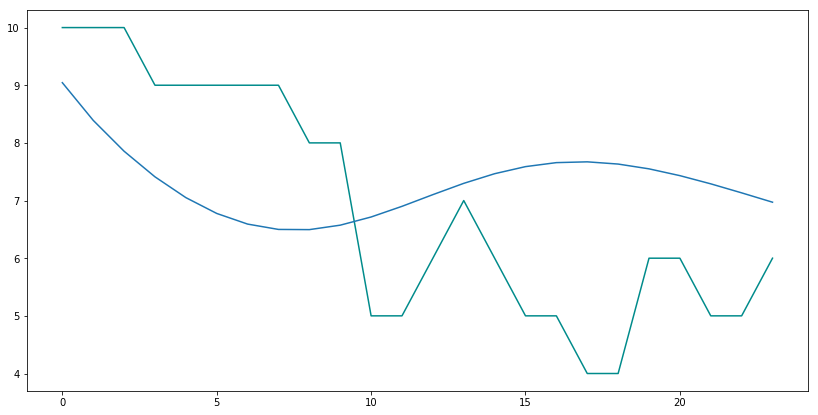

In [55]:
index=100
x = torch.FloatTensor(x_test_set[index])
# size=x_valid_set.size(0)
# print(y_valid_set)
num_steps = 24  # Do not set to higher value due to memory constraint
full_predictions = predict_full_sequence(model, x, input_size, num_steps,pm25_index)
fig = plt.figure(figsize=(14, 7))
# plt.plot(range(0, x.size(0)), x[:,pm25_index].data.numpy(), color="royalblue", label="Inputs")
y=y_test_set.squeeze(1)[index:index+num_steps,pm25_index]
plt.plot(y.data.numpy(),color='darkcyan')
plt.plot(full_predictions.data.numpy())

# plt.plot(range(x.size(0), x.size(0)+num_steps), y_valid_set[:,pm25_index].data.numpy(), color="darkcyan", label="True")
# plt.plot(range(x.size(0), x.size(0)+num_steps), full_predictions.data.numpy(),
#             color="tomato", label="Predictions")
# plt.legend(loc="upper right", fontsize=14)

plt.show()

In [28]:
print(full_predictions)

tensor([ 9.2646,  8.5441,  7.8071,  7.1583,  6.6569,  6.3403,  6.2225,
         6.2909,  6.5109,  6.8333,  7.2044,  7.5749,  7.9061,  8.1730,
         8.3647,  8.4821,  8.5350,  8.5384,  8.5089,  8.4621,  8.4114,
         8.3673,  8.3377,  8.3283])


In [53]:
y.shape

torch.Size([24, 13])

In [58]:
def eval_loss(model,input_size,pm25_index,num_steps,y_valid_set,x_valid_set,loss_fn):
    total_loss=0
    losses=[]
    for i in range(y_valid_set.size(0)-num_steps):
        index=i
        x = torch.FloatTensor(x_valid_set[index])
        # size=x_valid_set.size(0)
        # print(y_valid_set)
        full_predictions = predict_full_sequence(model, x, input_size, num_steps,pm25_index)
        y=y_valid_set.squeeze(1)[index:index+num_steps,pm25_index]
        loss=loss_fn(full_predictions,y)
        total_loss+=torch.sqrt(loss)
        losses.append(torch.sqrt(loss))
    return total_loss/y_valid_set.size(0),losses

tensor(4.2085)


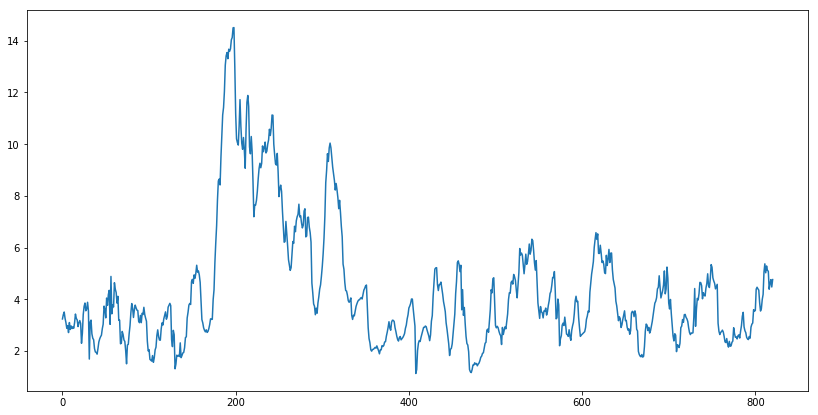

In [59]:
num_steps=24
loss_fn=nn.MSELoss()
loss,losses=eval_loss(model,input_size,pm25_index,num_steps,y_test_set,x_test_set,loss_fn)
print(loss)
fig = plt.figure(figsize=(14, 7))
plt.plot(losses)
plt.show()

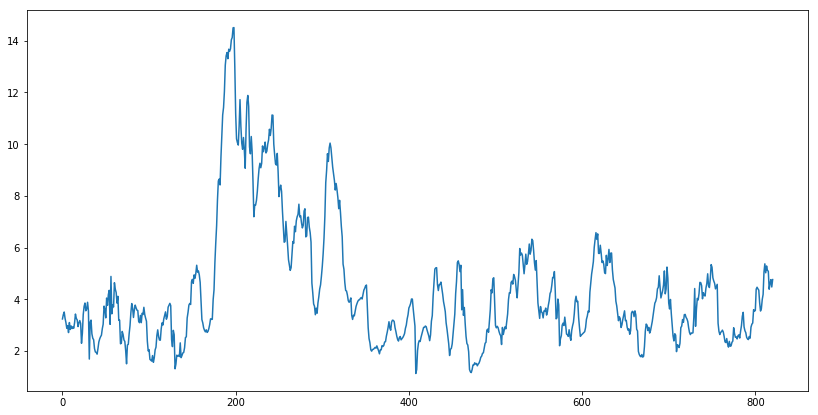

In [60]:
fig = plt.figure(figsize=(14, 7))
plt.plot(losses[:])
plt.show()